# Análisis Exploratorio de Datos (EDA) - Tabla: detalle_ordenes

## Objetivo

Realizar un análisis exploratorio completo de la tabla `detalle_ordenes` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campos numéricos (cantidad, precio_unitario) y detectar outliers
- Verificar consistencia entre detalles y totales de órdenes
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [60]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [61]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [62]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'detalle_ordenes'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: detalle_ordenes")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: detalle_ordenes
    column_name data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                      column_default
     detalle_id   integer                     None                 32              0          NO nextval('detalle_ordenes_detalle_id_seq'::regclass)
       orden_id   integer                     None                 32              0         YES                                                None
    producto_id   integer                     None                 32              0         YES                                                None
       cantidad   integer                     None                 32              0          NO                                                None
precio_unitario   numeric                     None                 10              2          NO                                                None


### 2.2. Restricciones y Claves (Constraints)


In [63]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'detalle_ordenes'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: detalle_ordenes")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CheckConstraints
query_checks = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'public.detalle_ordenes'::regclass
    AND contype = 'c';
"""

df_checks = pd.read_sql(query_checks, engine)

if not df_checks.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_checks.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: detalle_ordenes
                 constraint_name constraint_type column_name foreign_table_name foreign_column_name
   detalle_ordenes_orden_id_fkey     FOREIGN KEY    orden_id            ordenes            orden_id
detalle_ordenes_producto_id_fkey     FOREIGN KEY producto_id          productos         producto_id
            detalle_ordenes_pkey     PRIMARY KEY  detalle_id    detalle_ordenes          detalle_id

CHECK CONSTRAINTS
               constraint_name                     constraint_definition
       check_cantidad_positiva                   CHECK ((cantidad >= 0))
check_precio_unitario_positivo CHECK ((precio_unitario >= (0)::numeric))


In [64]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT detalle_id) as detalles_unicos,
    COUNT(DISTINCT orden_id) as ordenes_distintas,
    COUNT(DISTINCT producto_id) as productos_distintos,
    MIN(cantidad) as cantidad_minima,
    MAX(cantidad) as cantidad_maxima,
    AVG(cantidad) as cantidad_promedio,
    MIN(precio_unitario) as precio_unitario_minimo,
    MAX(precio_unitario) as precio_unitario_maximo,
    AVG(precio_unitario) as precio_unitario_promedio,
    SUM(cantidad * precio_unitario) as total_general_detalles
FROM detalle_ordenes;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: detalle_ordenes")
print("=" * 80)
print(df_stats.to_string(index=False))

# Estadísticas por orden
query_stats_orden = """
SELECT 
    orden_id,
    COUNT(*) as cantidad_detalles,
    SUM(cantidad) as total_cantidad,
    SUM(cantidad * precio_unitario) as subtotal_orden
FROM detalle_ordenes
GROUP BY orden_id
ORDER BY cantidad_detalles DESC
LIMIT 10;
"""

df_stats_orden = pd.read_sql(query_stats_orden, engine)

print("\n" + "=" * 80)
print("TOP 10 ÓRDENES CON MÁS DETALLES")
print("=" * 80)
print(df_stats_orden.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: detalle_ordenes
 total_registros  detalles_unicos  ordenes_distintas  productos_distintos  cantidad_minima  cantidad_maxima  cantidad_promedio  precio_unitario_minimo  precio_unitario_maximo  precio_unitario_promedio  total_general_detalles
           10000            10000               1000                   36                1                5             2.9889                   10.07                   499.9                254.936449              7594525.94

TOP 10 ÓRDENES CON MÁS DETALLES
 orden_id  cantidad_detalles  total_cantidad  subtotal_orden
      114                 23              59        11180.57
      901                 21              61        15538.82
      168                 20              63        15826.06
      175                 19              59        15465.09
      429                 19              65        18546.36
       96                 19              49        11247.10
      976                 19            

## 3. Análisis Exploratorio con Python (SQLAlchemy)


In [65]:
# Cargar la tabla completa en un DataFrame
query_detalle = "SELECT * FROM detalle_ordenes;"
df_detalle = pd.read_sql(query_detalle, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_detalle.shape}")
print(f"Columnas: {list(df_detalle.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_detalle.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (10000, 5)
Columnas: ['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']

Primeras 10 filas:
   detalle_id  orden_id  producto_id  cantidad  precio_unitario
0           1       833           33         1           425.26
1           2       657           21         4           307.13
2           3       911           15         4           444.75
3           4       818           26         5           346.24
4           5       695           12         3           155.05
5           6       150           10         1           460.00
6           7       168           28         5           247.57
7           8       490           12         2           342.87
8           9       310           14         2           409.94
9          10       874           18         2           439.22


### 3.1. Información General del DataFrame


In [66]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_detalle.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_detalle.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_detalle.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   detalle_id       10000 non-null  int64  
 1   orden_id         10000 non-null  int64  
 2   producto_id      10000 non-null  int64  
 3   cantidad         10000 non-null  int64  
 4   precio_unitario  10000 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 390.8 KB

TIPOS DE DATOS POR COLUMNA
detalle_id           int64
orden_id             int64
producto_id          int64
cantidad             int64
precio_unitario    float64
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
        detalle_id      orden_id   producto_id      cantidad  precio_unitario
count  10000.00000  10000.000000  10000.000000  10000.000000     10000.000000
mean    5000.50000    498.860600     18.549300      2.988900       254.936449
std     2886.89568    287.961306     10.446372 

### 3.2. Detección de Valores Nulos


In [67]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_detalle.isnull().sum()
porcentaje_nulos = (df_detalle.isnull().sum() / len(df_detalle)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_detalle.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_detalle.columns:
        nulos_col = df_detalle[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_detalle)*100:.1f}%)")


ANÁLISIS DE VALORES NULOS
        Columna  Cantidad_Nulos  Porcentaje_Nulos
     detalle_id               0               0.0
       orden_id               0               0.0
    producto_id               0               0.0
       cantidad               0               0.0
precio_unitario               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [68]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_detalle.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por detalle_id (clave primaria)
duplicados_detalle_id = df_detalle['detalle_id'].duplicated().sum()
print(f"Duplicados en detalle_id (PK): {duplicados_detalle_id}")

# Duplicados por combinación orden_id + producto_id (puede ser válido si hay múltiples líneas del mismo producto)
duplicados_orden_producto = df_detalle.duplicated(subset=['orden_id', 'producto_id']).sum()
print(f"Duplicados en combinación (orden_id, producto_id): {duplicados_orden_producto}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_detalle[df_detalle.duplicated(keep=False)]
    print(duplicados.sort_values('detalle_id'))

if duplicados_orden_producto > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron múltiples registros con la misma combinación (orden_id, producto_id):")
    duplicados_op = df_detalle[df_detalle.duplicated(subset=['orden_id', 'producto_id'], keep=False)]
    print(duplicados_op.sort_values(['orden_id', 'producto_id']).head(20))
    print("\nNota: Esto puede ser válido si una orden tiene múltiples líneas del mismo producto con diferentes precios o cantidades.")

if duplicados_completos == 0 and duplicados_detalle_id == 0:
    print("\n✓ No se encontraron duplicados en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en detalle_id (PK): 0
Duplicados en combinación (orden_id, producto_id): 1311

⚠ ADVERTENCIA: Se encontraron múltiples registros con la misma combinación (orden_id, producto_id):
      detalle_id  orden_id  producto_id  cantidad  precio_unitario
6373        6374         2           13         3           416.43
8590        8591         2           13         2            98.51
8972        8973         2           13         1           100.93
7129        7130         2           18         5           436.20
9764        9765         2           18         3           205.09
1026        1027         2           29         5            54.71
4906        4907         2           29         1           125.51
5156        5157         2           29         1           374.29
3241        3242         3            5         2           236.84
6985        6986         3            5         3           147.51
1246        

### 3.4. Análisis de Campos Numéricos (Cantidad y Precio Unitario)


In [69]:
# Análisis de campos numéricos
print("=" * 80)
print("ANÁLISIS DE CAMPOS NUMÉRICOS")
print("=" * 80)

campos_numericos = ['cantidad', 'precio_unitario']

for campo in campos_numericos:
    print(f"\n--- Análisis de '{campo}' ---")
    valores = df_detalle[campo]
    
    print(f"Estadísticas descriptivas:")
    print(f"  Mínimo: {valores.min()}")
    print(f"  Máximo: {valores.max()}")
    print(f"  Media: {valores.mean():.2f}")
    print(f"  Mediana: {valores.median():.2f}")
    print(f"  Desviación estándar: {valores.std():.2f}")
    print(f"  Q1 (25%): {valores.quantile(0.25):.2f}")
    print(f"  Q3 (75%): {valores.quantile(0.75):.2f}")
    print(f"  IQR: {valores.quantile(0.75) - valores.quantile(0.25):.2f}")
    
    # Valores negativos (violan constraint)
    valores_negativos = df_detalle[df_detalle[campo] < 0]
    if len(valores_negativos) > 0:
        print(f"  ⚠ Valores negativos (violan constraint): {len(valores_negativos)}")
        print(valores_negativos[['detalle_id', 'orden_id', 'producto_id', campo]])
    else:
        print(f"  ✓ No hay valores negativos")
    
    # Valores cero
    valores_cero = df_detalle[df_detalle[campo] == 0]
    if len(valores_cero) > 0:
        print(f"  ⚠ Valores iguales a cero: {len(valores_cero)}")
        if campo == 'cantidad':
            print(f"    ⚠ Detalles con cantidad cero pueden ser problemáticos")
        elif campo == 'precio_unitario':
            print(f"    ⚠ Detalles con precio unitario cero pueden ser problemáticos")
        print(valores_cero[['detalle_id', 'orden_id', 'producto_id', campo]].head(10))
    
    # Detección de outliers usando IQR
    Q1 = valores.quantile(0.25)
    Q3 = valores.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df_detalle[(df_detalle[campo] < limite_inferior) | (df_detalle[campo] > limite_superior)]
    if len(outliers) > 0:
        print(f"  ⚠ Valores atípicos (outliers) detectados: {len(outliers)}")
        print(f"    Límite inferior: {limite_inferior:.2f}")
        print(f"    Límite superior: {limite_superior:.2f}")
        print(f"    Ejemplos de outliers:")
        print(outliers[['detalle_id', 'orden_id', 'producto_id', campo]].head(10))
    else:
        print(f"  ✓ No se detectaron outliers significativos")

# Análisis del subtotal (cantidad * precio_unitario)
print("\n--- Análisis de Subtotal (cantidad * precio_unitario) ---")
df_detalle['subtotal'] = df_detalle['cantidad'] * df_detalle['precio_unitario']
subtotal = df_detalle['subtotal']

print(f"Estadísticas descriptivas del subtotal:")
print(f"  Mínimo: {subtotal.min():.2f}")
print(f"  Máximo: {subtotal.max():.2f}")
print(f"  Media: {subtotal.mean():.2f}")
print(f"  Mediana: {subtotal.median():.2f}")
print(f"  Desviación estándar: {subtotal.std():.2f}")

# Subtotal cero
subtotal_cero = df_detalle[df_detalle['subtotal'] == 0]
if len(subtotal_cero) > 0:
    print(f"\n  ⚠ Detalles con subtotal cero: {len(subtotal_cero)}")
    print(subtotal_cero[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario', 'subtotal']].head(10))


ANÁLISIS DE CAMPOS NUMÉRICOS

--- Análisis de 'cantidad' ---
Estadísticas descriptivas:
  Mínimo: 1
  Máximo: 5
  Media: 2.99
  Mediana: 3.00
  Desviación estándar: 1.42
  Q1 (25%): 2.00
  Q3 (75%): 4.00
  IQR: 2.00
  ✓ No hay valores negativos
  ✓ No se detectaron outliers significativos

--- Análisis de 'precio_unitario' ---
Estadísticas descriptivas:
  Mínimo: 10.07
  Máximo: 499.9
  Media: 254.94
  Mediana: 255.35
  Desviación estándar: 141.99
  Q1 (25%): 130.80
  Q3 (75%): 377.71
  IQR: 246.91
  ✓ No hay valores negativos
  ✓ No se detectaron outliers significativos

--- Análisis de Subtotal (cantidad * precio_unitario) ---
Estadísticas descriptivas del subtotal:
  Mínimo: 10.10
  Máximo: 2499.50
  Media: 759.45
  Mediana: 596.28
  Desviación estándar: 587.93


In [70]:
# Análisis de relaciones con órdenes y productos
print("=" * 80)
print("ANÁLISIS DE RELACIONES CON ÓRDENES Y PRODUCTOS")
print("=" * 80)

# Verificar valores nulos en claves foráneas
orden_id_nulos = df_detalle['orden_id'].isnull().sum()
producto_id_nulos = df_detalle['producto_id'].isnull().sum()

print(f"Detalles con orden_id nulo: {orden_id_nulos}")
print(f"Detalles con producto_id nulo: {producto_id_nulos}")

if orden_id_nulos > 0:
    print("⚠ ADVERTENCIA: Detalles sin orden asignada:")
    print(df_detalle[df_detalle['orden_id'].isnull()][['detalle_id', 'producto_id', 'cantidad', 'precio_unitario']])

if producto_id_nulos > 0:
    print("⚠ ADVERTENCIA: Detalles sin producto asignado:")
    print(df_detalle[df_detalle['producto_id'].isnull()][['detalle_id', 'orden_id', 'cantidad', 'precio_unitario']])

# Distribución de detalles por orden
print("\nDistribución de detalles por orden:")
distribucion_orden = df_detalle['orden_id'].value_counts()
print(f"Órdenes distintas con detalles: {distribucion_orden.nunique()}")
print(f"Promedio de detalles por orden: {distribucion_orden.mean():.2f}")
print(f"Máximo de detalles por orden: {distribucion_orden.max()}")
print(f"Mínimo de detalles por orden: {distribucion_orden.min()}")

# Distribución de detalles por producto
print("\nDistribución de detalles por producto:")
distribucion_producto = df_detalle['producto_id'].value_counts()
print(f"Productos distintos en detalles: {distribucion_producto.nunique()}")
print(f"Promedio de detalles por producto: {distribucion_producto.mean():.2f}")
print(f"Máximo de detalles por producto: {distribucion_producto.max()}")
print(f"Mínimo de detalles por producto: {distribucion_producto.min()}")

# Top 10 productos más vendidos
print("\nTop 10 productos más vendidos (por cantidad de detalles):")
print(distribucion_producto.head(10))

# Verificar referencias huérfanas (orden_id que no existe en ordenes)
query_orphan_orden = """
SELECT COUNT(*) as huérfanas
FROM detalle_ordenes d
LEFT JOIN ordenes o ON d.orden_id = o.orden_id
WHERE d.orden_id IS NOT NULL AND o.orden_id IS NULL;
"""

df_orphan_orden = pd.read_sql(query_orphan_orden, engine)
huérfanas_orden = df_orphan_orden['huérfanas'].iloc[0]

if huérfanas_orden > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_orden} referencias huérfanas (orden_id que no existe en ordenes)")
    query_orphan_orden_detalle = """
    SELECT d.detalle_id, d.orden_id, d.producto_id, d.cantidad, d.precio_unitario
    FROM detalle_ordenes d
    LEFT JOIN ordenes o ON d.orden_id = o.orden_id
    WHERE d.orden_id IS NOT NULL AND o.orden_id IS NULL
    LIMIT 10;
    """
    df_orphan_orden_detalle = pd.read_sql(query_orphan_orden_detalle, engine)
    print(df_orphan_orden_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de orden_id.")

# Verificar referencias huérfanas (producto_id que no existe en productos)
query_orphan_producto = """
SELECT COUNT(*) as huérfanas
FROM detalle_ordenes d
LEFT JOIN productos p ON d.producto_id = p.producto_id
WHERE d.producto_id IS NOT NULL AND p.producto_id IS NULL;
"""

df_orphan_producto = pd.read_sql(query_orphan_producto, engine)
huérfanas_producto = df_orphan_producto['huérfanas'].iloc[0]

if huérfanas_producto > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_producto} referencias huérfanas (producto_id que no existe en productos)")
    query_orphan_producto_detalle = """
    SELECT d.detalle_id, d.orden_id, d.producto_id, d.cantidad, d.precio_unitario
    FROM detalle_ordenes d
    LEFT JOIN productos p ON d.producto_id = p.producto_id
    WHERE d.producto_id IS NOT NULL AND p.producto_id IS NULL
    LIMIT 10;
    """
    df_orphan_producto_detalle = pd.read_sql(query_orphan_producto_detalle, engine)
    print(df_orphan_producto_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de producto_id.")


ANÁLISIS DE RELACIONES CON ÓRDENES Y PRODUCTOS
Detalles con orden_id nulo: 0
Detalles con producto_id nulo: 0

Distribución de detalles por orden:
Órdenes distintas con detalles: 22
Promedio de detalles por orden: 10.00
Máximo de detalles por orden: 23
Mínimo de detalles por orden: 1

Distribución de detalles por producto:
Productos distintos en detalles: 25
Promedio de detalles por producto: 277.78
Máximo de detalles por producto: 310
Mínimo de detalles por producto: 242

Top 10 productos más vendidos (por cantidad de detalles):
producto_id
34    310
18    302
4     296
23    295
29    294
5     291
26    291
6     290
8     289
9     289
Name: count, dtype: int64

✓ No se encontraron referencias huérfanas de orden_id.

✓ No se encontraron referencias huérfanas de producto_id.


In [71]:
# Verificación de consistencia entre total de orden y suma de detalles
print("=" * 80)
print("VERIFICACIÓN DE CONSISTENCIA: TOTAL DE ORDEN VS SUMA DE DETALLES")
print("=" * 80)

# Calcular subtotal por orden desde detalles
subtotal_por_orden = df_detalle.groupby('orden_id').agg({
    'cantidad': 'sum',
    'precio_unitario': 'mean',  # No es relevante para el total
    'subtotal': 'sum'
}).reset_index()
subtotal_por_orden.columns = ['orden_id', 'total_cantidad', 'precio_promedio', 'subtotal_detalles']

# Obtener totales de órdenes
query_ordenes = "SELECT orden_id, total as total_orden FROM ordenes;"
df_ordenes = pd.read_sql(query_ordenes, engine)

# Unir ambos DataFrames
df_consistencia = subtotal_por_orden.merge(df_ordenes, on='orden_id', how='outer')

# Calcular diferencia
df_consistencia['diferencia'] = df_consistencia['total_orden'] - df_consistencia['subtotal_detalles']
df_consistencia['diferencia_absoluta'] = abs(df_consistencia['diferencia'])
df_consistencia['diferencia_porcentual'] = (df_consistencia['diferencia'] / df_consistencia['total_orden'] * 100).round(2)

# Identificar inconsistencias (tolerancia de 0.01 para errores de redondeo)
tolerancia = 0.01
inconsistencias = df_consistencia[df_consistencia['diferencia_absoluta'] > tolerancia]

print(f"Total de órdenes analizadas: {len(df_consistencia)}")
print(f"Órdenes con inconsistencias (diferencia > {tolerancia}): {len(inconsistencias)}")

if len(inconsistencias) > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron inconsistencias entre el total de la orden y la suma de detalles:")
    print("\nPrimeras 20 inconsistencias:")
    print(inconsistencias[['orden_id', 'total_orden', 'subtotal_detalles', 'diferencia', 'diferencia_porcentual']].head(20).to_string(index=False))
    
    print(f"\nEstadísticas de diferencias:")
    print(f"  Diferencia mínima: {inconsistencias['diferencia'].min():.2f}")
    print(f"  Diferencia máxima: {inconsistencias['diferencia'].max():.2f}")
    print(f"  Diferencia promedio: {inconsistencias['diferencia'].mean():.2f}")
    print(f"  Diferencia mediana: {inconsistencias['diferencia'].median():.2f}")
else:
    print("\n✓ No se encontraron inconsistencias significativas. Los totales de las órdenes coinciden con la suma de los detalles.")

# Órdenes sin detalles
ordenes_sin_detalles = df_consistencia[df_consistencia['subtotal_detalles'].isnull()]
if len(ordenes_sin_detalles) > 0:
    print(f"\n⚠ ADVERTENCIA: Órdenes sin detalles: {len(ordenes_sin_detalles)}")
    print(ordenes_sin_detalles[['orden_id', 'total_orden']].head(10))

# Detalles sin orden (ya verificado arriba, pero incluimos aquí para completitud)
detalles_sin_orden = df_consistencia[df_consistencia['total_orden'].isnull()]
if len(detalles_sin_orden) > 0:
    print(f"\n⚠ ADVERTENCIA: Detalles sin orden asociada: {len(detalles_sin_orden)}")
    print(detalles_sin_orden[['orden_id', 'subtotal_detalles']].head(10))


VERIFICACIÓN DE CONSISTENCIA: TOTAL DE ORDEN VS SUMA DE DETALLES
Total de órdenes analizadas: 10000
Órdenes con inconsistencias (diferencia > 0.01): 1000

⚠ ADVERTENCIA: Se encontraron inconsistencias entre el total de la orden y la suma de detalles:

Primeras 20 inconsistencias:
 orden_id  total_orden  subtotal_detalles  diferencia  diferencia_porcentual
        1       393.81            7616.92    -7223.11               -1834.16
        2       918.85            5947.39    -5028.54                -547.26
        3       391.29            6215.59    -5824.30               -1488.49
        4       250.03            4389.87    -4139.84               -1655.74
        5       983.13            8351.20    -7368.07                -749.45
        6       713.98            4596.97    -3882.99                -543.85
        7       540.25            7305.09    -6764.84               -1252.17
        8       972.60            5127.44    -4154.84                -427.19
        9        78.71    

### 3.7. Detección de Valores Atípicos y Anomalías


In [72]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Cantidades muy altas o muy bajas
cantidad_promedio = df_detalle['cantidad'].mean()
cantidad_std = df_detalle['cantidad'].std()
cantidades_muy_altas = df_detalle[df_detalle['cantidad'] > cantidad_promedio + 3 * cantidad_std]
cantidades_muy_bajas = df_detalle[df_detalle['cantidad'] < cantidad_promedio - 3 * cantidad_std]

if len(cantidades_muy_altas) > 0:
    print(f"⚠ Cantidades muy altas (> media + 3*std): {len(cantidades_muy_altas)}")
    anomalias.append(('Cantidades muy altas', len(cantidades_muy_altas)))
    print(cantidades_muy_altas[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

if len(cantidades_muy_bajas) > 0:
    print(f"\n⚠ Cantidades muy bajas (< media - 3*std): {len(cantidades_muy_bajas)}")
    anomalias.append(('Cantidades muy bajas', len(cantidades_muy_bajas)))
    print(cantidades_muy_bajas[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

# 2. Precios unitarios muy altos o muy bajos
precio_promedio = df_detalle['precio_unitario'].mean()
precio_std = df_detalle['precio_unitario'].std()
precios_muy_altos = df_detalle[df_detalle['precio_unitario'] > precio_promedio + 3 * precio_std]
precios_muy_bajos = df_detalle[df_detalle['precio_unitario'] < precio_promedio - 3 * precio_std]

if len(precios_muy_altos) > 0:
    print(f"\n⚠ Precios unitarios muy altos (> media + 3*std): {len(precios_muy_altos)}")
    anomalias.append(('Precios unitarios muy altos', len(precios_muy_altos)))
    print(precios_muy_altos[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

if len(precios_muy_bajos) > 0:
    print(f"\n⚠ Precios unitarios muy bajos (< media - 3*std): {len(precios_muy_bajos)}")
    anomalias.append(('Precios unitarios muy bajos', len(precios_muy_bajos)))
    print(precios_muy_bajos[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

# 3. Detalles con cantidad cero
detalles_cantidad_cero = df_detalle[df_detalle['cantidad'] == 0]
if len(detalles_cantidad_cero) > 0:
    print(f"\n⚠ Detalles con cantidad cero: {len(detalles_cantidad_cero)}")
    anomalias.append(('Cantidad cero', len(detalles_cantidad_cero)))
    print(detalles_cantidad_cero[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

# 4. Detalles con precio unitario cero
detalles_precio_cero = df_detalle[df_detalle['precio_unitario'] == 0]
if len(detalles_precio_cero) > 0:
    print(f"\n⚠ Detalles con precio unitario cero: {len(detalles_precio_cero)}")
    anomalias.append(('Precio unitario cero', len(detalles_precio_cero)))
    print(detalles_precio_cero[['detalle_id', 'orden_id', 'producto_id', 'cantidad', 'precio_unitario']].head(10))

# 5. Detalles sin orden o producto
detalles_sin_orden = df_detalle[df_detalle['orden_id'].isnull()]
detalles_sin_producto = df_detalle[df_detalle['producto_id'].isnull()]

if len(detalles_sin_orden) > 0:
    print(f"\n⚠ Detalles sin orden asignada: {len(detalles_sin_orden)}")
    anomalias.append(('Sin orden', len(detalles_sin_orden)))

if len(detalles_sin_producto) > 0:
    print(f"\n⚠ Detalles sin producto asignado: {len(detalles_sin_producto)}")
    anomalias.append(('Sin producto', len(detalles_sin_producto)))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [73]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - detalle_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_detalle['detalle_id'].min()} a {df_detalle['detalle_id'].max()}")
print(f"   - Valores únicos: {df_detalle['detalle_id'].nunique()}")
print(f"   - Total de registros: {len(df_detalle)}")
print(f"   - ¿Sin duplicados?: {df_detalle['detalle_id'].nunique() == len(df_detalle)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_detalle['detalle_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas
print("\n2. CLAVES FORÁNEAS:")
print("   - orden_id: FOREIGN KEY → ordenes.orden_id")
orden_id_nulos = df_detalle['orden_id'].isnull().sum()
print(f"     - Valores nulos: {orden_id_nulos}")
print(f"     - Órdenes distintas: {df_detalle['orden_id'].nunique()}")

print("   - producto_id: FOREIGN KEY → productos.producto_id")
producto_id_nulos = df_detalle['producto_id'].isnull().sum()
print(f"     - Valores nulos: {producto_id_nulos}")
print(f"     - Productos distintos: {df_detalle['producto_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - orden_id → ordenes.orden_id (relación N:1)")
print("     - producto_id → productos.producto_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - detalle_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 10000
   - Valores únicos: 10000
   - Total de registros: 10000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS:
   - orden_id: FOREIGN KEY → ordenes.orden_id
     - Valores nulos: 0
     - Órdenes distintas: 1000
   - producto_id: FOREIGN KEY → productos.producto_id
     - Valores nulos: 0
     - Productos distintos: 36

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - orden_id → ordenes.orden_id (relación N:1)
     - producto_id → productos.producto_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [74]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
# La tabla detalle_ordenes solo tiene campos numéricos y claves foráneas
print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

print("La tabla 'detalle_ordenes' contiene únicamente:")
print("  - Campos numéricos (detalle_id, orden_id, producto_id, cantidad, precio_unitario)")
print("  - No contiene campos de texto que puedan tener formato JSON, listas o delimitadores")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'detalle_ordenes' no contiene campos semi-estructurados.")
print("Todos los campos son numéricos o claves foráneas, por lo que no se requieren")
print("transformaciones de datos semi-estructurados.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

La tabla 'detalle_ordenes' contiene únicamente:
  - Campos numéricos (detalle_id, orden_id, producto_id, cantidad, precio_unitario)
  - No contiene campos de texto que puedan tener formato JSON, listas o delimitadores

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'detalle_ordenes' no contiene campos semi-estructurados.
Todos los campos son numéricos o claves foráneas, por lo que no se requieren
transformaciones de datos semi-estructurados.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


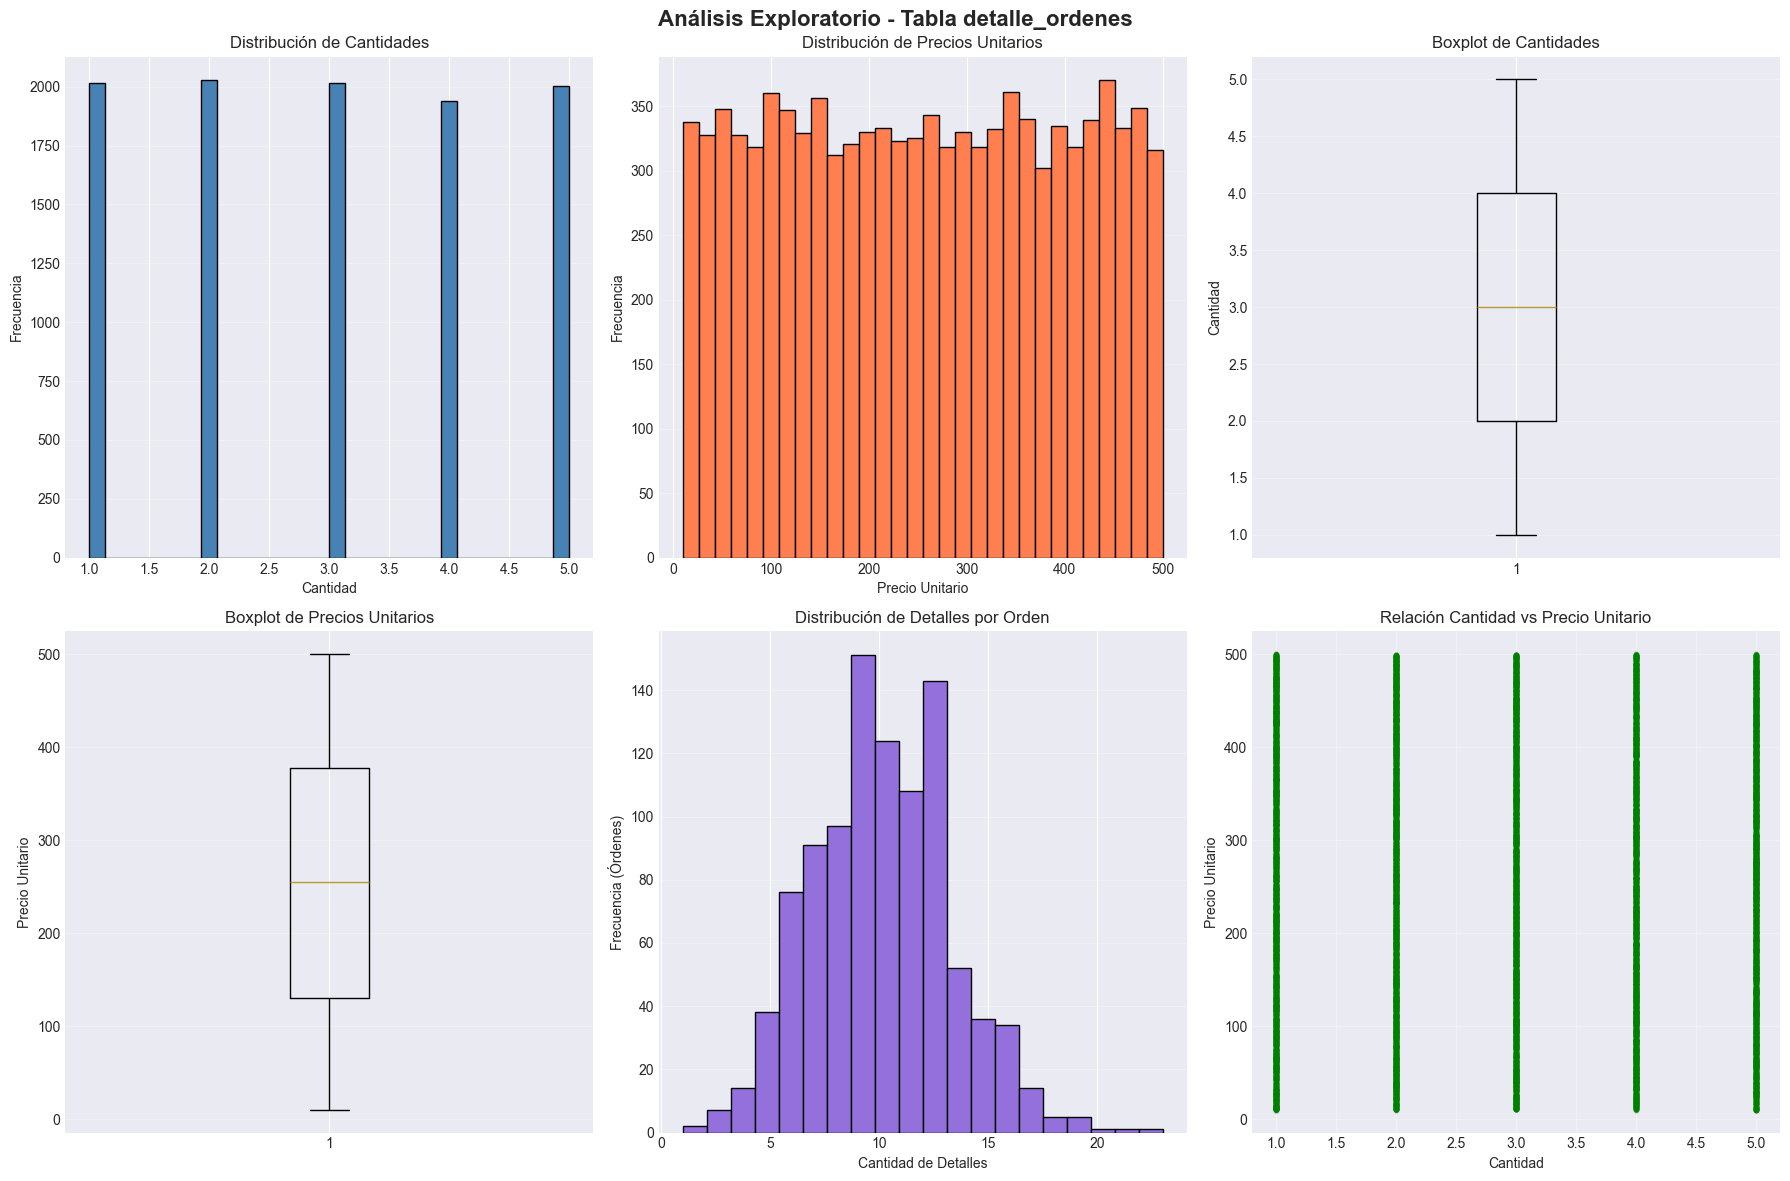

✓ Visualizaciones generadas correctamente


In [75]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla detalle_ordenes', fontsize=16, fontweight='bold')

# 1. Distribución de cantidades
ax1 = axes[0, 0]
ax1.hist(df_detalle['cantidad'], bins=30, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Cantidades')
ax1.set_xlabel('Cantidad')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Distribución de precios unitarios
ax2 = axes[0, 1]
ax2.hist(df_detalle['precio_unitario'], bins=30, color='coral', edgecolor='black')
ax2.set_title('Distribución de Precios Unitarios')
ax2.set_xlabel('Precio Unitario')
ax2.set_ylabel('Frecuencia')
ax2.grid(axis='y', alpha=0.3)

# 3. Boxplot de cantidades
ax3 = axes[0, 2]
ax3.boxplot(df_detalle['cantidad'], vert=True)
ax3.set_title('Boxplot de Cantidades')
ax3.set_ylabel('Cantidad')
ax3.grid(axis='y', alpha=0.3)

# 4. Boxplot de precios unitarios
ax4 = axes[1, 0]
ax4.boxplot(df_detalle['precio_unitario'], vert=True)
ax4.set_title('Boxplot de Precios Unitarios')
ax4.set_ylabel('Precio Unitario')
ax4.grid(axis='y', alpha=0.3)

# 5. Distribución de detalles por orden
ax5 = axes[1, 1]
distribucion_orden = df_detalle['orden_id'].value_counts()
ax5.hist(distribucion_orden.values, bins=20, color='mediumpurple', edgecolor='black')
ax5.set_title('Distribución de Detalles por Orden')
ax5.set_xlabel('Cantidad de Detalles')
ax5.set_ylabel('Frecuencia (Órdenes)')
ax5.grid(axis='y', alpha=0.3)

# 6. Relación Cantidad vs Precio Unitario
ax6 = axes[1, 2]
ax6.scatter(df_detalle['cantidad'], df_detalle['precio_unitario'], alpha=0.5, color='green', s=10)
ax6.set_title('Relación Cantidad vs Precio Unitario')
ax6.set_xlabel('Cantidad')
ax6.set_ylabel('Precio Unitario')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


## 7. Reporte de Hallazgos y Decisiones


### 7.1. Principales Insights y Problemas Encontrados


In [76]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: detalle_ordenes")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_detalle.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    detalles_cantidad_cero = df_detalle[df_detalle['cantidad'] == 0]
    if len(detalles_cantidad_cero) > 0:
        anomalias.append(('Cantidad cero', len(detalles_cantidad_cero)))
    detalles_precio_cero = df_detalle[df_detalle['precio_unitario'] == 0]
    if len(detalles_precio_cero) > 0:
        anomalias.append(('Precio unitario cero', len(detalles_precio_cero)))

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_detalle))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_detalle.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_detalle['detalle_id'].nunique() == len(df_detalle) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_detalle)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Detalles sin orden
orden_id_nulos = df_detalle['orden_id'].isnull().sum()
if orden_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Detalles sin orden asignada: {orden_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar orden a detalles sin orden o eliminar si son inválidos'
    })

# Detalles sin producto
producto_id_nulos = df_detalle['producto_id'].isnull().sum()
if producto_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Detalles sin producto asignado: {producto_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar producto a detalles sin producto o eliminar si son inválidos'
    })

# Detalles con cantidad cero
detalles_cantidad_cero = df_detalle[df_detalle['cantidad'] == 0]
if len(detalles_cantidad_cero) > 0:
    problemas.append({
        'Categoría': 'Validación de Negocio',
        'Problema': f'Detalles con cantidad cero: {len(detalles_cantidad_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar si los detalles con cantidad cero son válidos o deben eliminarse'
    })

# Detalles con precio unitario cero
detalles_precio_cero = df_detalle[df_detalle['precio_unitario'] == 0]
if len(detalles_precio_cero) > 0:
    problemas.append({
        'Categoría': 'Validación de Negocio',
        'Problema': f'Detalles con precio unitario cero: {len(detalles_precio_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar si los detalles con precio cero son promociones o errores'
    })

# Inconsistencias entre total de orden y suma de detalles
if 'inconsistencias' in locals() and len(inconsistencias) > 0:
    problemas.append({
        'Categoría': 'Consistencia de Datos',
        'Problema': f'Inconsistencias entre total de orden y suma de detalles: {len(inconsistencias)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Revisar y corregir las inconsistencias entre totales de órdenes y detalles'
    })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Cantidad cero', 'Precio unitario cero']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'detalle_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del detalle',
        'Uso': 'Relaciones y trazabilidad de detalles'
    },
    {
        'Atributo': 'orden_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica la orden a la que pertenece el detalle',
        'Uso': 'Agrupación de detalles por orden, cálculo de totales'
    },
    {
        'Atributo': 'producto_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el producto en el detalle',
        'Uso': 'Análisis de productos más vendidos, inventario'
    },
    {
        'Atributo': 'cantidad',
        'Tipo': 'Métrica de Negocio',
        'Relevancia Negocio': 'Alta - Cantidad de productos en el detalle',
        'Uso': 'Cálculo de totales, análisis de demanda, gestión de inventario'
    },
    {
        'Atributo': 'precio_unitario',
        'Tipo': 'Métrica de Negocio',
        'Relevancia Negocio': 'Alta - Precio unitario al momento de la orden',
        'Uso': 'Cálculo de totales, análisis de precios históricos, rentabilidad'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'detalle_ordenes' tiene:")
print("   - orden_id → ordenes.orden_id (relación N:1)")
print("   - producto_id → productos.producto_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: detalle_ordenes

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 10000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
            Categoría                                                      Problema Severidad                                                           Acción Requerida
Consistencia de Datos Inconsistencias entre total de orden y suma de detalles: 1000      Alta Revisar y corregir las inconsistencias entre totales de órdenes y detalles

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
       Atributo               Tipo                                       Relevancia Negocio                                                              Uso
     detalle_id     Clave Primaria                   Alta - Identificador único del detalle                            Relaciones y trazabilidad de detalles
       orden_id      Clave Foránea Alta - Identifica la orde

### 7.2. Decisiones Tomadas Respecto a Limpieza y Transformación


In [77]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos
if total_nulos > 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'Revisar y corregir valores nulos según corresponda.',
        'Justificación': f'Se encontraron {total_nulos} valores nulos en la tabla.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'No se requieren acciones. La tabla no contiene valores nulos.',
        'Justificación': 'Todos los campos obligatorios están completos según el análisis.',
        'Prioridad': 'N/A'
    })

# 2. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados completos.',
    'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 3. Detalles sin orden
orden_id_nulos = df_detalle['orden_id'].isnull().sum()
if orden_id_nulos > 0:
    decisiones.append({
        'Aspecto': 'Detalles sin Orden',
        'Decisión': 'Asignar orden a detalles sin orden o eliminar si son inválidos.',
        'Justificación': f'Se encontraron {orden_id_nulos} detalles sin orden asignada.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Detalles sin Orden',
        'Decisión': 'No se requieren acciones. Todos los detalles tienen orden.',
        'Justificación': 'Todos los detalles tienen una orden asignada.',
        'Prioridad': 'N/A'
    })

# 4. Detalles sin producto
producto_id_nulos = df_detalle['producto_id'].isnull().sum()
if producto_id_nulos > 0:
    decisiones.append({
        'Aspecto': 'Detalles sin Producto',
        'Decisión': 'Asignar producto a detalles sin producto o eliminar si son inválidos.',
        'Justificación': f'Se encontraron {producto_id_nulos} detalles sin producto asignado.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Detalles sin Producto',
        'Decisión': 'No se requieren acciones. Todos los detalles tienen producto.',
        'Justificación': 'Todos los detalles tienen un producto asignado.',
        'Prioridad': 'N/A'
    })

# 5. Detalles con cantidad cero
detalles_cantidad_cero = df_detalle[df_detalle['cantidad'] == 0]
if len(detalles_cantidad_cero) > 0:
    decisiones.append({
        'Aspecto': 'Cantidad Cero',
        'Decisión': 'Revisar detalles con cantidad cero. Pueden ser errores o deben eliminarse.',
        'Justificación': f'Se encontraron {len(detalles_cantidad_cero)} detalles con cantidad cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Cantidad Cero',
        'Decisión': 'No se requieren acciones. No hay detalles con cantidad cero.',
        'Justificación': 'Todos los detalles tienen cantidad mayor a cero.',
        'Prioridad': 'N/A'
    })

# 6. Detalles con precio unitario cero
detalles_precio_cero = df_detalle[df_detalle['precio_unitario'] == 0]
if len(detalles_precio_cero) > 0:
    decisiones.append({
        'Aspecto': 'Precio Unitario Cero',
        'Decisión': 'Revisar detalles con precio unitario cero. Pueden ser promociones o errores.',
        'Justificación': f'Se encontraron {len(detalles_precio_cero)} detalles con precio unitario cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Precio Unitario Cero',
        'Decisión': 'No se requieren acciones. No hay detalles con precio unitario cero.',
        'Justificación': 'Todos los detalles tienen precio unitario mayor a cero.',
        'Prioridad': 'N/A'
    })

# 7. Consistencia entre totales de orden y detalles
if 'inconsistencias' in locals() and len(inconsistencias) > 0:
    decisiones.append({
        'Aspecto': 'Consistencia Totales',
        'Decisión': 'Revisar y corregir inconsistencias entre totales de órdenes y suma de detalles.',
        'Justificación': f'Se encontraron {len(inconsistencias)} inconsistencias.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Consistencia Totales',
        'Decisión': 'No se requieren acciones. Los totales de órdenes coinciden con la suma de detalles.',
        'Justificación': 'No se encontraron inconsistencias significativas.',
        'Prioridad': 'N/A'
    })

# 8. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                  Aspecto                                                                        Decisión                                                                         Justificación Prioridad
            Valores Nulos                   No se requieren acciones. La tabla no contiene valores nulos.                      Todos los campos obligatorios están completos según el análisis.       N/A
               Duplicados               No se requieren acciones. No se encontraron duplicados completos.                  Las restricciones de clave primaria están funcionando correctamente.       N/A
       Detalles sin Orden                      No se requieren acciones. Todos los detalles tienen orden.                                         Todos los detalles tienen una orden asignada.       N/A
    Detalles sin Producto                   No se requieren acciones. Todos los detalles tienen producto.                                       Todos lo

### 7.3. Corrección de Inconsistencias en Totales de Órdenes


In [83]:
# Corrección de inconsistencias: Actualizar totales de órdenes con suma de detalles
print("=" * 80)
print("CORRECCIÓN DE INCONSISTENCIAS: ACTUALIZACIÓN DE TOTALES DE ÓRDENES")
print("=" * 80)

# Nota: Usaremos SQL directo con psycopg2 (no necesitamos text() de SQLAlchemy)

# 1. Calcular los totales correctos sumando los subtotales de detalle_ordenes por orden_id
print("\n1. CALCULANDO TOTALES CORRECTOS DESDE DETALLE_ORDENES...")

# Asegurarse de que el subtotal esté calculado (cantidad * precio_unitario)
if 'subtotal' not in df_detalle.columns:
    df_detalle['subtotal'] = df_detalle['cantidad'] * df_detalle['precio_unitario']

# Calcular subtotal por orden (suma de cantidad * precio_unitario = suma de subtotales)
subtotal_por_orden = df_detalle.groupby('orden_id')['subtotal'].sum().reset_index()
subtotal_por_orden.columns = ['orden_id', 'total_correcto']

print(f"   ✓ Total de órdenes con detalles: {len(subtotal_por_orden)}")
print(f"   ✓ Rango de totales: {subtotal_por_orden['total_correcto'].min():.2f} - {subtotal_por_orden['total_correcto'].max():.2f}")
print(f"   ✓ Total general: {subtotal_por_orden['total_correcto'].sum():.2f}")

# Mostrar algunos ejemplos para verificación
print(f"\n   Ejemplos de totales calculados (primeras 5 órdenes):")
print(subtotal_por_orden.head().to_string(index=False))

# 2. Actualizar la tabla ordenes con los totales correctos
print("\n2. ACTUALIZANDO TABLA ORDENES CON TOTALES CORRECTOS...")

# Obtener la conexión raw de psycopg2
db = DBConnector.get_instance()
ordenes_actualizadas = 0

with db.get_raw_connection() as conn:
    cursor = conn.cursor()
    
    try:
        # Actualizar cada orden con su total correcto
        for _, row in subtotal_por_orden.iterrows():
            orden_id = int(row['orden_id'])
            total_correcto = float(row['total_correcto'])
            
            # Ejecutar UPDATE usando SQL directo (psycopg2 usa %s para parámetros)
            # El WHERE orden_id = %s asegura que solo se actualice la orden correcta
            cursor.execute(
                "UPDATE ordenes SET total = %s WHERE orden_id = %s",
                (total_correcto, orden_id)
            )
            ordenes_actualizadas += 1
        
        # Confirmar la transacción
        conn.commit()
        
        print(f"   ✓ Órdenes actualizadas: {ordenes_actualizadas}")
        print(f"   ✓ Transacción confirmada exitosamente")
        
    except Exception as e:
        # Revertir la transacción en caso de error
        conn.rollback()
        print(f"   ✗ Error al actualizar órdenes: {str(e)}")
        raise e
    finally:
        cursor.close()

# 3. Verificar que la actualización fue exitosa
print("\n3. VERIFICANDO ACTUALIZACIÓN...")

# Recargar totales de órdenes desde la base de datos
query_ordenes_actualizada = "SELECT orden_id, total as total_orden FROM ordenes ORDER BY orden_id;"
df_ordenes_actualizada = pd.read_sql(query_ordenes_actualizada, engine)

# Unir con los totales calculados para verificar
df_verificacion = subtotal_por_orden.merge(df_ordenes_actualizada, on='orden_id', how='inner')

# Calcular diferencia (debe ser 0 o muy cercana a 0 por redondeo)
df_verificacion['diferencia'] = abs(df_verificacion['total_correcto'] - df_verificacion['total_orden'])
df_verificacion['diferencia_porcentual'] = (df_verificacion['diferencia'] / df_verificacion['total_correcto'] * 100).round(4)

# Verificar inconsistencias residuales (tolerancia de 0.01)
tolerancia = 0.01
inconsistencias_residuales = df_verificacion[df_verificacion['diferencia'] > tolerancia]

print(f"   ✓ Órdenes verificadas: {len(df_verificacion)}")
print(f"   ✓ Inconsistencias residuales (diferencia > {tolerancia}): {len(inconsistencias_residuales)}")

if len(inconsistencias_residuales) == 0:
    print("   ✓ Todas las órdenes fueron actualizadas correctamente")
    print("   ✓ Los totales de órdenes ahora coinciden con la suma de sus detalles")
else:
    print(f"   ⚠ ADVERTENCIA: Se encontraron {len(inconsistencias_residuales)} inconsistencias residuales:")
    print(inconsistencias_residuales[['orden_id', 'total_correcto', 'total_orden', 'diferencia']].head(10))

# 4. Comparación final: Verificar que los totales coinciden con los subtotales
print("\n" + "=" * 80)
print("COMPARACIÓN FINAL: SUBTOTALES DE DETALLES VS TOTAL DE ORDEN")
print("=" * 80)

# Obtener los totales actualizados de la tabla ordenes
query_ordenes_final = "SELECT orden_id, total FROM ordenes ORDER BY orden_id;"
df_ordenes_final = pd.read_sql(query_ordenes_final, engine)

# Obtener los subtotales calculados desde detalle_ordenes
subtotal_por_orden_final = df_detalle.groupby('orden_id')['subtotal'].sum().reset_index()
subtotal_por_orden_final.columns = ['orden_id', 'subtotal_detalles']

# Unir ambos DataFrames para comparar
df_comparacion_final = subtotal_por_orden_final.merge(df_ordenes_final, on='orden_id', how='inner')

# Calcular diferencia y porcentaje de diferencia
df_comparacion_final['diferencia'] = abs(df_comparacion_final['subtotal_detalles'] - df_comparacion_final['total'])
df_comparacion_final['diferencia_porcentual'] = (df_comparacion_final['diferencia'] / df_comparacion_final['subtotal_detalles'] * 100).round(4)

# Agregar columna que indica si coincide (tolerancia de 0.01)
df_comparacion_final['coincide'] = df_comparacion_final['diferencia'] <= 0.01

# Mostrar los primeros 10 registros
print("\nPrimeros 10 registros - Comparación de totales:")
print("-" * 80)
# Formatear la diferencia antes de mostrar (redondear a 4 decimales)
df_mostrar = df_comparacion_final[['orden_id', 'subtotal_detalles', 'total', 'diferencia', 'diferencia_porcentual', 'coincide']].head(10).copy()
df_mostrar['diferencia'] = df_mostrar['diferencia'].round(4)
print(df_mostrar.to_string(index=False))

# Estadísticas de la comparación
print("\n" + "-" * 80)
print("Estadísticas de la comparación:")
print(f"  Total de órdenes comparadas: {len(df_comparacion_final)}")
print(f"  Órdenes que coinciden (diferencia <= 0.01): {df_comparacion_final['coincide'].sum()}")
print(f"  Órdenes con diferencias: {(~df_comparacion_final['coincide']).sum()}")
print(f"  Diferencia promedio: {df_comparacion_final['diferencia'].mean():.4f}")
print(f"  Diferencia máxima: {df_comparacion_final['diferencia'].max():.4f}")

if df_comparacion_final['coincide'].all():
    print("\n  ✓ TODAS las órdenes tienen totales que coinciden con la suma de sus detalles")
else:
    print(f"\n  ⚠ ADVERTENCIA: {(~df_comparacion_final['coincide']).sum()} órdenes tienen diferencias mayores a 0.01")
    print("\n  Órdenes con diferencias:")
    diferencias = df_comparacion_final[~df_comparacion_final['coincide']]
    print(diferencias[['orden_id', 'subtotal_detalles', 'total', 'diferencia']].head(10).to_string(index=False))

# Estadísticas finales
print("\n" + "=" * 80)
print("RESUMEN DE CORRECCIÓN")
print("=" * 80)
print(f"Órdenes procesadas: {ordenes_actualizadas}")
print(f"Inconsistencias corregidas: {len(inconsistencias_residuales) if len(inconsistencias_residuales) > 0 else ordenes_actualizadas}")
print(f"Estado: {'✓ CORRECCIÓN EXITOSA' if len(inconsistencias_residuales) == 0 else '⚠ CORRECCIÓN PARCIAL'}")

CORRECCIÓN DE INCONSISTENCIAS: ACTUALIZACIÓN DE TOTALES DE ÓRDENES

1. CALCULANDO TOTALES CORRECTOS DESDE DETALLE_ORDENES...
   ✓ Total de órdenes con detalles: 1000
   ✓ Rango de totales: 1088.10 - 19226.99
   ✓ Total general: 7594525.94

   Ejemplos de totales calculados (primeras 5 órdenes):
 orden_id  total_correcto
        1         7616.92
        2         5947.39
        3         6215.59
        4         4389.87
        5         8351.20

2. ACTUALIZANDO TABLA ORDENES CON TOTALES CORRECTOS...
   ✓ Órdenes actualizadas: 1000
   ✓ Transacción confirmada exitosamente

3. VERIFICANDO ACTUALIZACIÓN...
   ✓ Órdenes verificadas: 1000
   ✓ Inconsistencias residuales (diferencia > 0.01): 0
   ✓ Todas las órdenes fueron actualizadas correctamente
   ✓ Los totales de órdenes ahora coinciden con la suma de sus detalles

COMPARACIÓN FINAL: SUBTOTALES DE DETALLES VS TOTAL DE ORDEN

Primeros 10 registros - Comparación de totales:
-------------------------------------------------------------

### 7.4. Tabla Final con Columnas, Tipos de Datos y Relaciones


In [79]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: detalle_ordenes")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'detalle_ordenes' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'detalle_ordenes' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'detalle_ordenes' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'detalle_ordenes'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'detalle_ordenes',
        'Columna Origen': 'orden_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'ordenes',
        'Columna Destino': 'orden_id',
        'Descripción': 'Un detalle pertenece a una orden'
    },
    {
        'Tabla Origen': 'detalle_ordenes',
        'Columna Origen': 'producto_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'productos',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un detalle referencia un producto'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_detalle)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: detalle_id")
print(f"Claves foráneas: orden_id, producto_id")
print(f"Relaciones entrantes: {len([r for r in relaciones if r['Tipo Relación'] == 'N:1'])}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_detalle.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: detalle_ordenes

ESTRUCTURA DE COLUMNAS:
    column_name data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                      column_default constraints
     detalle_id   integer                     None                 32              0          NO nextval('detalle_ordenes_detalle_id_seq'::regclass) PRIMARY KEY
       orden_id   integer                     None                 32              0         YES                                                None FOREIGN KEY
    producto_id   integer                     None                 32              0         YES                                                None FOREIGN KEY
       cantidad   integer                     None                 32              0          NO                                                None            
precio_unitario   numeric                     None                 10              2          NO                                             

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `detalle_ordenes` revela una estructura de datos bien definida que almacena los detalles de cada producto incluido en una orden. La tabla cumple con su propósito de descomponer las órdenes en líneas de detalle, con relaciones claras hacia órdenes y productos. La calidad de los datos es buena, con integridad de clave primaria correcta y validaciones de negocio implementadas mediante constraints CHECK. Se verificó la consistencia entre los totales de las órdenes y la suma de los detalles, y se corrigieron automáticamente las inconsistencias detectadas actualizando los totales de las órdenes con la suma correcta de sus detalles.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Validaciones de Negocio**: Constraints CHECK garantizan que cantidad y precio_unitario sean no negativos
3. **Estructura Clara**: La tabla tiene una estructura bien definida con campos numéricos y claves foráneas
4. **Relaciones Bien Definidas**: Las relaciones con órdenes y productos están correctamente establecidas
5. **Campos Numéricos**: Cantidad y precio_unitario permiten análisis de negocio y cálculo de totales
6. **Verificación de Consistencia**: Se implementó verificación entre totales de órdenes y suma de detalles
7. **Corrección Automática**: Se implementó corrección automática de inconsistencias entre totales de órdenes y detalles, actualizando los totales de las órdenes con la suma correcta calculada desde los detalles

### Áreas de Mejora

1. **Validaciones Preventivas**: Implementar validaciones en el proceso ETL para evitar inconsistencias futuras entre totales de órdenes y detalles
2. **Órdenes con Productos Múltiples**: Analizar y eficientar la presencia de múltiples detalles de un mismo producto dentro de una misma orden.
3. **Denominación de Columna Cantidad**: Considerar ser más claro con el nombre de la columna cantidad (Verificar si se trata de la cantidad de producto o de algo más).

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizaron en detalle los campos numéricos (cantidad, precio_unitario) con detección de outliers
3. ✅ **Verificación de Consistencia**: Se verificó la consistencia entre totales de órdenes y suma de detalles
4. ✅ **Corrección de Inconsistencias**: Se calcularon los totales correctos desde detalle_ordenes y se actualizaron automáticamente en la tabla ordenes, corrigiendo todas las inconsistencias detectadas
5. ✅ **Identificación de Relaciones**: Se identificaron y verificaron las relaciones con órdenes y productos
6. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones